In [1]:
## imports
import sys
import os
import numpy as np
import xarray as xr
import cmocean
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import eofs
from eofs.xarray import Eof
import cftime
import nc_time_axis

import mtspec

# from pylab import *

import datetime
import time
import glob, os
import math
import matplotlib.colors as colors
import xesmf as xe
from defs import lon180cesm, lon180, salmask, latweights, makedz

In [2]:
datafolder = ''

In [3]:
experiment = 'E280' 
model = 'CCSM4'

if experiment == 'E280':
    preamble = 'b40.B1850.f09_g16.preind.pop.h.'
    preamble2 = '.0081-0180.annavg.nc'
else:
    preamble = 'b40.B1850.f09_g16.PMIP4-pliomip2.pop.h.'
    preamble2 = '.1001-1100.annavg.nc'

a = 'b40.B1850.f09_g16.PMIP4-pliomip2.pop.h.MOC.1001-1100.ann.nc'
folder = datafolder+'Raw_data/CCSM4/'

def filename(variable_string):
    filename = folder+experiment+'/'+preamble+variable_string+preamble2
    
    return filename

In [4]:
dsV = xr.open_dataset(filename('VVEL'))
dsT = xr.open_dataset(filename('TEMP'))
dsS = xr.open_dataset(filename('SALT'))
dsVNT = xr.open_dataset(filename('VNT'))

#Region mask contained in different files
if experiment == 'E280':
    ds = dsT.copy(deep=True)
else: 
    ds = dsVNT.copy(deep=True)
    
if experiment == 'E280':
    dsS = dsS.drop(['ULAT','ULONG','z_t_150m','z_w','z_w_top','z_w_bot','lat_aux_grid','moc_z'])
    dsV = dsV.drop(['TLAT','TLONG','z_t_150m','z_w','z_w_top','z_w_bot','lat_aux_grid','moc_z'])
else:
    ds = ds.drop(['ULAT','ULONG','z_t_150m','z_w','z_w_top','z_w_bot','lat_aux_grid','moc_z'])

## Separation MOC and gyre FW Atlantic

In [5]:
salt = dsS.SALT[0]
region = ds.REGION_MASK

regridder = xe.Regridder(dsV, dsS, 'bilinear', periodic = True, ignore_degenerate=True)
vo = dsV.VVEL[0].fillna(0)
vvel = regridder(vo)

/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/xesmf/frontend.py:522: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


In [6]:
#Define reference salinity S0 as mean Atlantic salinity
folder2 = datafolder+'Processed/'
dssal = xr.open_dataset(folder2+model+'/'+experiment+'/so_1x1_100yr.nc')
dssal = lon180(dssal)

S0 = dssal.so.where(salmask()>-1).weighted(makedz(dssal)).mean(dim='z').weighted(latweights()).mean()

In [7]:
SALT = salt.where(ds.REGION_MASK>5).where(ds.REGION_MASK<10)  
VVEL = vvel.where(ds.REGION_MASK>5).where(ds.REGION_MASK<10)
VVEL = VVEL*SALT/SALT #cm/s

In [8]:
def zonal_means(x, dx):
    xint = (x*dx).sum('nlon')  # [x-unit * cm]
    zm = xint/dx.sum('nlon')   # [x-unit]
    return zm

DXT = ds.DXT
dz = ds.dz

#zonal mean
VVEL_zm = zonal_means(VVEL, DXT.where(VVEL<10000))
SALT_zm = zonal_means(SALT, DXT.where(VVEL<10000))

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

# azonal components
SALT_prime = (SALT - SALT_zm_3D)  # azonal salt component (x,y,z) [g/kg]
VVEL_prime = (VVEL - VVEL_zm_3D)  # azonal velocity comp. (x,y,z) [cm/s]

#Integrate to obtain freshwater transports
Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*DXT*dz).sum(dim=['nlon','z_t']))/1e12 # 1 Sv = 1e12 cm^3/s
Faz = (-1/S0*(VVEL_prime*SALT_prime*DXT*dz).sum(dim=['nlon','z_t']))/1e12

Ftotal = (-1/S0*(VVEL*(SALT-S0)*DXT*dz).sum(dim=['nlon','z_t']))/1e12

In [9]:
# auxiliary latitudes 
lats = ds.TLAT.where(ds.REGION_MASK>5).where(ds.REGION_MASK<10).mean('nlon')

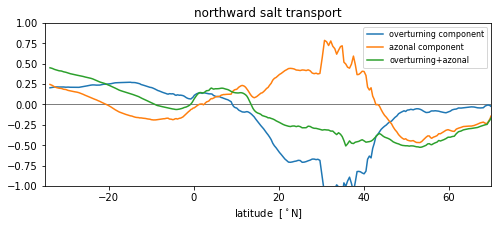

In [10]:
plt.figure(figsize=(8,3))
plt.axhline(0,c='k',lw=.5)
plt.plot(lats, Fov, label='overturning component')

plt.plot(lats, Faz, label='azonal component')
plt.plot(lats, Ftotal, label='overturning+azonal')
plt.title('northward salt transport')
plt.xlim([-35,70])
plt.ylim([-1,1])
plt.xlabel(r'latitude  [$^\circ$N]')
plt.legend(fontsize=8)

In [15]:
if experiment == 'E280':
    dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[85:-1]), Faz=(["lat"], Faz[85:-1]), Ftot=(["lat"], Ftotal[85:-1])), coords = dict(lat = lats[85:-1].values))
elif experiment == 'Eoi400':
    dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[95:-1]), Faz=(["lat"], Faz[95:-1]), Ftot=(["lat"], Ftotal[95:-1])), coords = dict(lat = lats[95:-1].values))
    
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_100yr.nc')

## FW Labrador

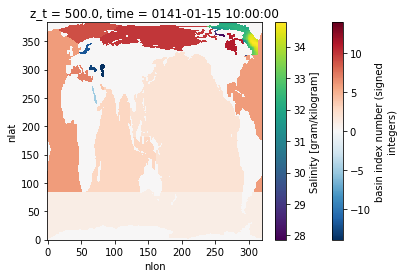

In [16]:
#visualize region
dsS = lon180cesm(dsS)

ds.REGION_MASK.plot()
dsS.SALT[0,0,:,:].where(ds.REGION_MASK>5).where(ds.REGION_MASK<10).where(dsS.TLONG<-45).where(ds.TLAT>=50).plot(cmap='viridis')

In [20]:
SALT = salt.where(ds.REGION_MASK>5).where(ds.REGION_MASK<10).where(dsS.TLONG<-45).where(ds.TLAT>=50)
VVEL = vvel.where(ds.REGION_MASK>5).where(ds.REGION_MASK<10).where(dsS.TLONG<-45).where(ds.TLAT>=50)
VVEL = VVEL*SALT/SALT #cm/s

DXT = ds.DXT
dz = ds.dz

#zonal means
VVEL_zm = zonal_means(VVEL, DXT.where(VVEL<10000))
SALT_zm = zonal_means(SALT, DXT.where(VVEL<10000))

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

# azonal components
SALT_prime = (SALT - SALT_zm_3D) 
VVEL_prime = (VVEL - VVEL_zm_3D)  

#Integrate for freshwater transports
Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*DXT*dz).sum(dim=['nlon','z_t']))/1e12 # 1 Sv = 1e12 cm^3/s
Faz = (-1/S0*(VVEL_prime*SALT_prime*DXT*dz).sum(dim=['nlon','z_t']))/1e12

Ftotal = (-1/S0*(VVEL*(SALT-S0)*DXT*dz).sum(dim=['nlon','z_t']))/1e12

# auxiliary latitudes for plotting
lats = ds.TLAT.where(ds.REGION_MASK>5).where(ds.REGION_MASK<10).where(dsS.TLONG<-45).where(ds.TLAT>=50).mean('nlon')

dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[-45:-21]), Faz=(["lat"], Faz[-45:-21]), Ftot=(["lat"], Ftotal[-45:-21])), coords = dict(lat = lats[-45:-21].values))
    
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_Lab_100yr.nc')

## FW Fram Strait

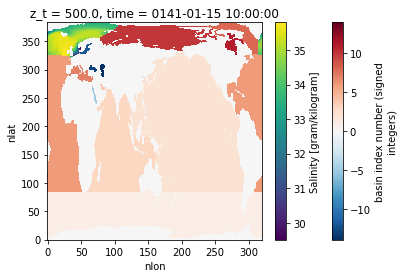

In [21]:
#Visualize region
ds.REGION_MASK.plot()
dsS.SALT[0,0,:,:].where(ds.REGION_MASK>5).where(ds.REGION_MASK<10).where(dsS.TLONG>=-45).where(ds.TLAT>=50).plot(cmap='viridis')

In [22]:
SALT = salt.where(ds.REGION_MASK>5).where(ds.REGION_MASK<10).where(dsS.TLONG>=-45).where(ds.TLAT>=50)
VVEL = vvel.where(ds.REGION_MASK>5).where(ds.REGION_MASK<10).where(dsS.TLONG>=-45).where(ds.TLAT>=50)
VVEL = VVEL*SALT/SALT #cm/s

DXT = ds.DXT
dz = ds.dz

#zonal meanas
VVEL_zm = zonal_means(VVEL, DXT.where(VVEL<10000))
SALT_zm = zonal_means(SALT, DXT.where(VVEL<10000))

SALT_zm_3D = SALT/SALT
SALT_zm_3D = SALT_zm_3D*SALT_zm

VVEL_zm_3D = VVEL/VVEL
VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

# azonal components
SALT_prime = (SALT - SALT_zm_3D)  # azonal salt component (x,y,z) []
VVEL_prime = (VVEL - VVEL_zm_3D)  # azonal velocity comp. (x,y,z) [cm/s]
    
#Integrate to obtain transports
Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*DXT*dz).sum(dim=['nlon','z_t']))/1e12 # 1 Sv = 1e12 cm^3/s
Faz = (-1/S0*(VVEL_prime*SALT_prime*DXT*dz).sum(dim=['nlon','z_t']))/1e12

Ftotal = (-1/S0*(VVEL*(SALT-S0)*DXT*dz).sum(dim=['nlon','z_t']))/1e12

# auxiliary latitudes
lats = ds.TLAT.where(ds.REGION_MASK>5).where(ds.REGION_MASK<10).where(dsS.TLONG>=-45).where(ds.TLAT>=50).mean('nlon')

dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[-45:-17]), Faz=(["lat"], Faz[-45:-17]), Ftot=(["lat"], Ftotal[-45:-17])), coords = dict(lat = lats[-45:-17].values))
    
xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_Fram_100yr.nc')

## FW Bering Strait

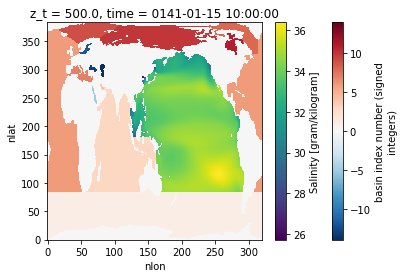

In [23]:
#visualize region
ds.REGION_MASK.plot()
dsS.SALT[0,0,:,:].where(ds.REGION_MASK==2).plot(cmap='viridis')

In [24]:
if experiment == 'E280':
    SALT = salt.where(ds.REGION_MASK==2) 
    VVEL = vvel.where(ds.REGION_MASK==2)
    VVEL = VVEL*SALT/SALT #cm/s

    DXT = ds.DXT
    dz = ds.dz
    
    #zonal mean
    VVEL_zm = zonal_means(VVEL, DXT.where(VVEL<10000))
    SALT_zm = zonal_means(SALT, DXT.where(VVEL<10000))

    SALT_zm_3D = SALT/SALT
    SALT_zm_3D = SALT_zm_3D*SALT_zm

    VVEL_zm_3D = VVEL/VVEL
    VVEL_zm_3D = VVEL_zm_3D*VVEL_zm

    # azonal components
    SALT_prime = (SALT - SALT_zm_3D) 
    VVEL_prime = (VVEL - VVEL_zm_3D) 

    #integrate to obtain freshwater transports
    Fov = (-1/S0*(VVEL_zm_3D*(SALT_zm_3D-S0)*DXT*dz).sum(dim=['nlon','z_t']))/1e12 # 1 Sv = 1e12 cm^3/s
    Faz = (-1/S0*(VVEL_prime*SALT_prime*DXT*dz).sum(dim=['nlon','z_t']))/1e12

    Ftotal = (-1/S0*(VVEL*(SALT-S0)*DXT*dz).sum(dim=['nlon','z_t']))/1e12

    # auxiliary latitudes
    lats = ds.TLAT.where(ds.REGION_MASK==2).mean('nlon')

    dsE = xr.Dataset(data_vars = dict(Fov=(["lat"], Fov[85:-50]), Faz=(["lat"], Faz[85:-50]), Ftot=(["lat"], Ftotal[85:-50])), coords = dict(lat = lats[85:-50].values))

    xr.Dataset.to_netcdf(dsE, path = datafolder+'Processed/'+model+'/'+experiment+'/decomFW_BS_100yr.nc')